## Подготовка датасета (формирование признаков, анализ признаков)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import rankdata
from scipy.stats import moment
from scipy.stats import skew, kurtosis
import pickle

In [2]:
def rank_peaks(data, height=1, notpeaks = 200):
    # Ранжирование пиков
    x = np.array(data)
    peaks_ind, peaks_vals = find_peaks(x, height=height)
    ranks = rankdata(peaks_vals['peak_heights'], method='dense')
    x[:] = notpeaks
    if peaks_ind!=[]:
        ranks = max(ranks) - ranks + 1
        x[peaks_ind] = ranks
    else:
        peaks_vals = {'peak_heights': np.array([0.])}
        peaks_ind = []
    result = {'x':x, 
              'peaks_number':len(peaks_ind), 
              'peaks_vals':peaks_vals}
    return result

def save_to_pickle(data, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

def load_from_pickle(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [14]:
data = pd.read_csv('radar_dataset.csv', sep=',')
data.shape

(500000, 8)

In [15]:
data.head()

,ais_id,num_profile,ship_length,ship_width,view_angle,distance_to_radar,marine_traffic_class,dimension_class
0,227023300,"[6, 11, 10, 9, 8, 12, 10, 7, 11, 12, 12, 14, 1...",104,22,-140.932090,11599.470782,None,0
1,227321490,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,6,-170.720077,27850.721576,None,2
2,352090000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",175,28,-165.621794,26609.081047,oil_products tanker,3
3,235029369,NaN,12,4,-135.948899,6268.161144,None,2
4,228179700,"[11, 15, 17, 9, 14, 27, 27, 18, 3, 9, 18, 11, ...",30,10,-43.317525,5163.925502,tug,2


In [16]:
data.dropna(inplace=True)

In [17]:
data.shape

(439463, 8)

In [18]:
# Количество различных судов в выборке
data['ais_id'].nunique()

442

In [19]:
# Типы судов и количество записей соответствующего типа в выборке
data['marine_traffic_class'].value_counts()

None                       130567
crude_oil tanker            62286
oil/chemical_tanker         55696
container_ship              41605
tug                         23164
ro-ro/passenger_ship        21078
general_cargo               18390
hopper_dredger              14098
oil_products tanker         13357
vehicles_carrier             9680
training_ship                7986
passenger_ship               6034
lpg_tanker                   5794
pilot_ship                   4699
trawler                      3339
fishing                      3328
bulk_carrier                 2390
yacht/pleasure_craft         2262
chemical_tanker              2138
sailing_vessel               2084
ro-ro_cargo                  1896
crewboat                     1616
asphalt/bitumen_tanker       1029
tanker                       1026
dry_cargo                     892
ro-ro/container_carrier       786
lh896354                      755
container                     303
high_speed craft              283
rescue/salvage

In [20]:
# Габаритные классы судов и количество записей соответствующего типа в выборке
data['dimension_class'].value_counts()

2    163429
1    114372
0     86918
3     74744
Name: dimension_class, dtype: int64

In [21]:
# Преобразуем данные радарного профиля к числовому типу
data['num_profile'] = data['num_profile'].apply(lambda s: list(s[1:-1].split(', ')))
data['num_profile'] = data['num_profile'].apply(lambda d: [int(el) for el in d])

# Выделим максимальное и минимальное значения
data['num_profile_max'] = data['num_profile'].apply(lambda d: max(d))
data['num_profile_min'] = data['num_profile'].apply(lambda d: min(d))

In [22]:
# Отфильруем записи, где одно и то же судно имеет разные габариты
data_aisid_grouped = data.groupby('ais_id')['ship_length', 'ship_width', 'view_angle', 'distance_to_radar', 'marine_traffic_class', 'dimension_class'].agg(['min','max','nunique'])
bad_ais = data_aisid_grouped[data_aisid_grouped[('ship_length', 'nunique')]>1].index
bad_ais = list(set(list(bad_ais) + list(data_aisid_grouped[data_aisid_grouped[('ship_width', 'nunique')]>1].index)))
bad_ais = list(set(list(bad_ais) + list(data_aisid_grouped[data_aisid_grouped[('dimension_class', 'nunique')]>1].index)))
data = data[data['ais_id'].isin(bad_ais)==False]

In [23]:
data.shape

(403419, 10)

In [24]:
# Уберем записи без метки класса
#data = data[data['marine_traffic_class']!='None']

In [25]:
# Уберем класс с одним единственным примером - мы не сможем его корректно классифицировать
data = data[data['marine_traffic_class'] != 'fishery_research vessel']

In [26]:
data.shape

(403418, 10)

In [28]:
data['num_profile'] = data['num_profile'].apply(lambda d: np.array(d))

In [52]:
%%time
# Отмасштабируем профиль на отрезок [0,1] пообъектно, округлим значения до 4х знаков после запятой
num_profile_scaled = data['num_profile'].apply(lambda d: [(a-np.min(d)) / (np.max(d)-np.min(d)) for a in d])
num_profile_scaled = list([np.round(v,4) for v in num_profile_scaled])
#data['num_profile_scaled'] = num_profile_scaled

Wall time: 15min 40s


In [53]:
save_to_pickle(num_profile_scaled, 'num_profile_scaled.pkl')

In [61]:
%%time
# Найдем пики радарного профиля и проранжируем их по убыванию. Таким образом сможем использовать ранги пиков вместо абсолютных значений
data['result'] = data['num_profile'].apply(lambda d: rank_peaks(d, height=1, notpeaks = 200))
data['ranked_values'] = data['result'].apply(lambda s: s['x'])
data['peaks_number'] = data['result'].apply(lambda s: s['peaks_number'])
data['peaks_vals'] = data['result'].apply(lambda s: s['peaks_vals']['peak_heights'])
# peak to peak
data['peak2peak'] = data['peaks_vals'].apply(lambda d: np.ptp(d))
data.drop('result', inplace=True, axis=1)
# Дополним массив пиков нулями до 200 элементов, чтобы можно было дальше работать с массивами одинаковой длины
data['peaks_vals'] = data['peaks_vals'].apply(lambda a: np.pad(a, mode='constant', pad_width=(0,200-len(a)), constant_values=0))
data['peaks_vals_sorted'] = data['peaks_vals'].apply(lambda d: np.flip(np.sort(d)))

data['nonzero_count'] = data['num_profile'].apply(lambda d: np.count_nonzero(d))
data['p0p1'] = data['peaks_vals_sorted'].apply(lambda d: d[0]/(d[1]+1))
data['p1p2'] = data['peaks_vals_sorted'].apply(lambda d: d[1]/(d[2]+1))
data['p2p3'] = data['peaks_vals_sorted'].apply(lambda d: d[2]/(d[3]+1))
data['p3p4'] = data['peaks_vals_sorted'].apply(lambda d: d[3]/(d[4]+1))
data['p4p5'] = data['peaks_vals_sorted'].apply(lambda d: d[4]/(d[5]+1))

data['m0'] = data['num_profile'].apply(lambda d: np.mean(d))
data['m1'] = data['num_profile'].apply(lambda d: np.mean(d**2))
data['mass_center'] = data['m1']/(data['m0']+1)
data['mc2'] = data['num_profile'].apply(lambda d: moment(d, moment=2))
data['mc3'] = data['num_profile'].apply(lambda d: moment(d, moment=3))
data['mass_center_rel'] = data['mass_center']/(data['peak2peak']+1)
data['mc2_n'] = data['mc2']/(data['m0']+1)
data['mc3_n'] = data['mc3']/(data['m0']+1)
data['num_median'] = data['num_profile'].apply(lambda d: np.median(d))
data['num_skew'] = data['num_profile'].apply(lambda d: skew(d))
data['num_kurtosis'] = data['num_profile'].apply(lambda d: kurtosis(d))

Wall time: 3min 41s


In [62]:
data.drop('num_profile_scaled', inplace=True, axis=1)

In [64]:
save_to_pickle(data, 'dataset.pkl')

In [63]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ais_id,403418.0,2.809985e+08,1.009711e+08,2.051530e+08,2.273152e+08,2.350593e+08,2.569020e+08,6.360928e+08
ship_length,403418.0,1.383209e+02,1.155209e+02,0.000000e+00,1.600000e+01,1.150000e+02,2.440000e+02,4.000000e+02
ship_width,403418.0,2.310961e+01,1.802200e+01,0.000000e+00,6.000000e+00,1.800000e+01,3.600000e+01,6.000000e+01
view_angle,403418.0,1.880346e+00,1.107486e+02,-1.799995e+02,-9.282073e+01,2.332702e+00,9.540777e+01,1.799988e+02
distance_to_radar,403418.0,2.186869e+04,1.562489e+04,7.444847e+02,8.559075e+03,1.836479e+04,2.897994e+04,9.232359e+04
dimension_class,403418.0,1.504653e+00,1.014313e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
num_profile_max,403418.0,9.103699e+01,3.177519e+01,1.200000e+01,6.700000e+01,9.300000e+01,1.170000e+02,2.550000e+02
num_profile_min,403418.0,8.925730e-01,3.448662e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e+01
peaks_number,403418.0,3.293721e+01,1.648438e+01,1.000000e+00,1.800000e+01,3.600000e+01,4.700000e+01,7.300000e+01
peak2peak,403418.0,8.691430e+01,2.925821e+01,0.000000e+00,6.500000e+01,9.100000e+01,1.110000e+02,2.540000e+02


#### Построим boxplot'ы и посмотрим, насколько хорошо отдельные признаки разделяют классы

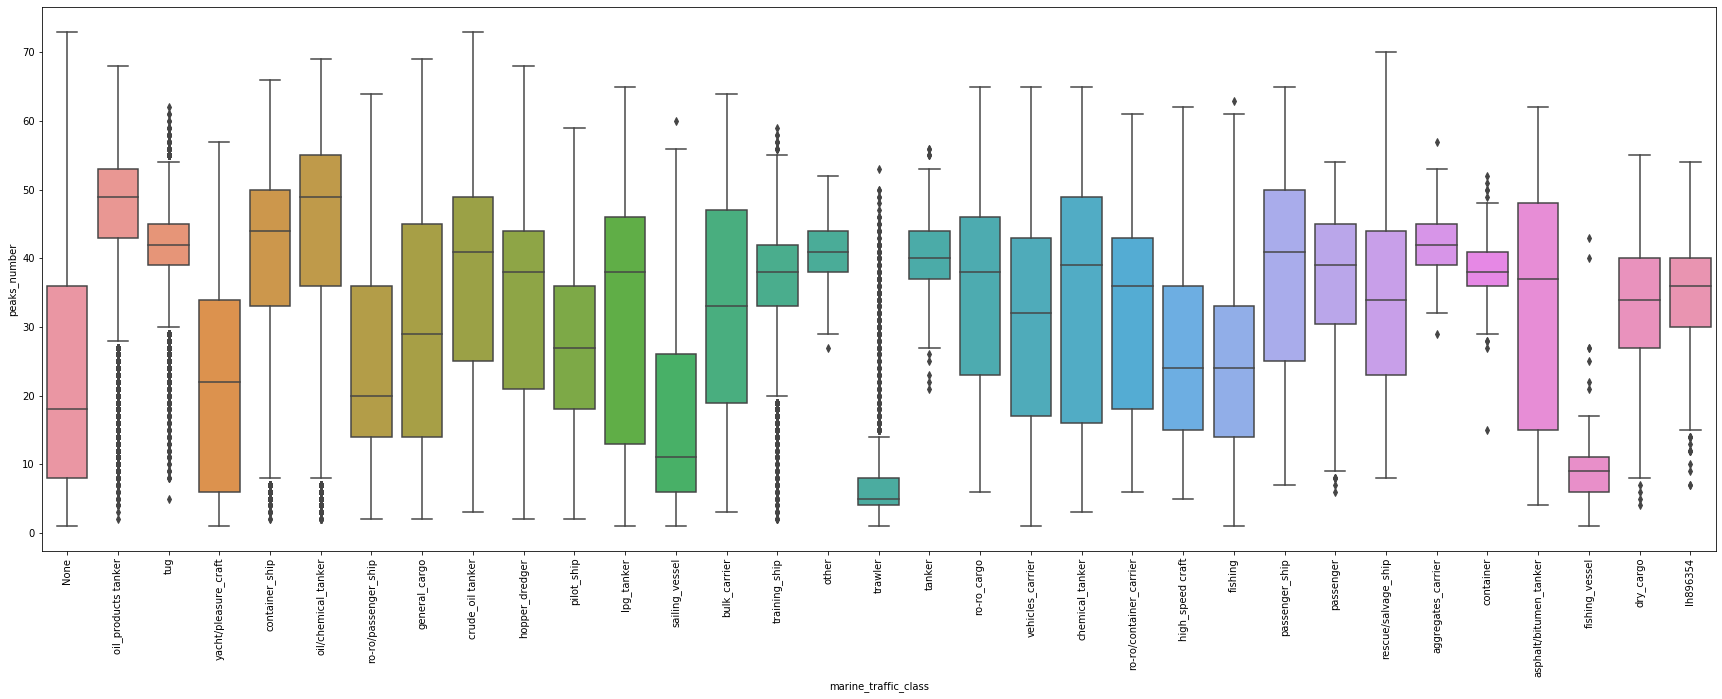

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10))
plt.xticks(rotation='vertical')
sns.boxplot(x="marine_traffic_class", y="peaks_number", data=data, ax=ax)

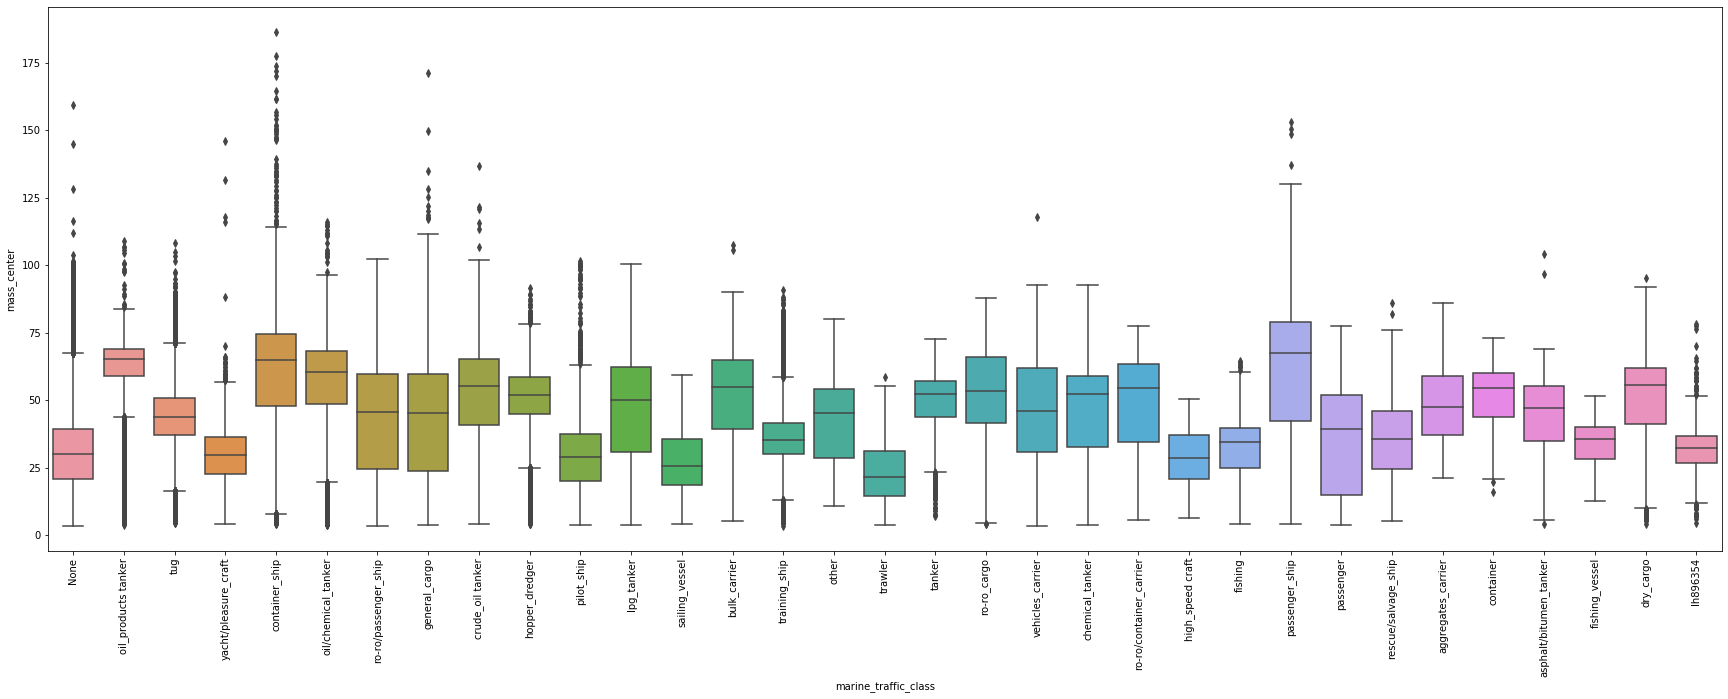

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10))
plt.xticks(rotation='vertical')
sns.boxplot(x="marine_traffic_class", y="mass_center", data=data, ax=ax)

#### Посмотрим на корреляции между признаками. Это пригодится при моделировании - не будем одновременно включать в модели признаки, имеющие очень большую взаимную корреляцию

In [77]:
def draw_heatmap(data, corrtype = 'pearson'):
    corr = data.corr(method=corrtype)
    # Генерируем маску для отсечения верхней диагонали матрицы
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(45, 20))
    
    sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

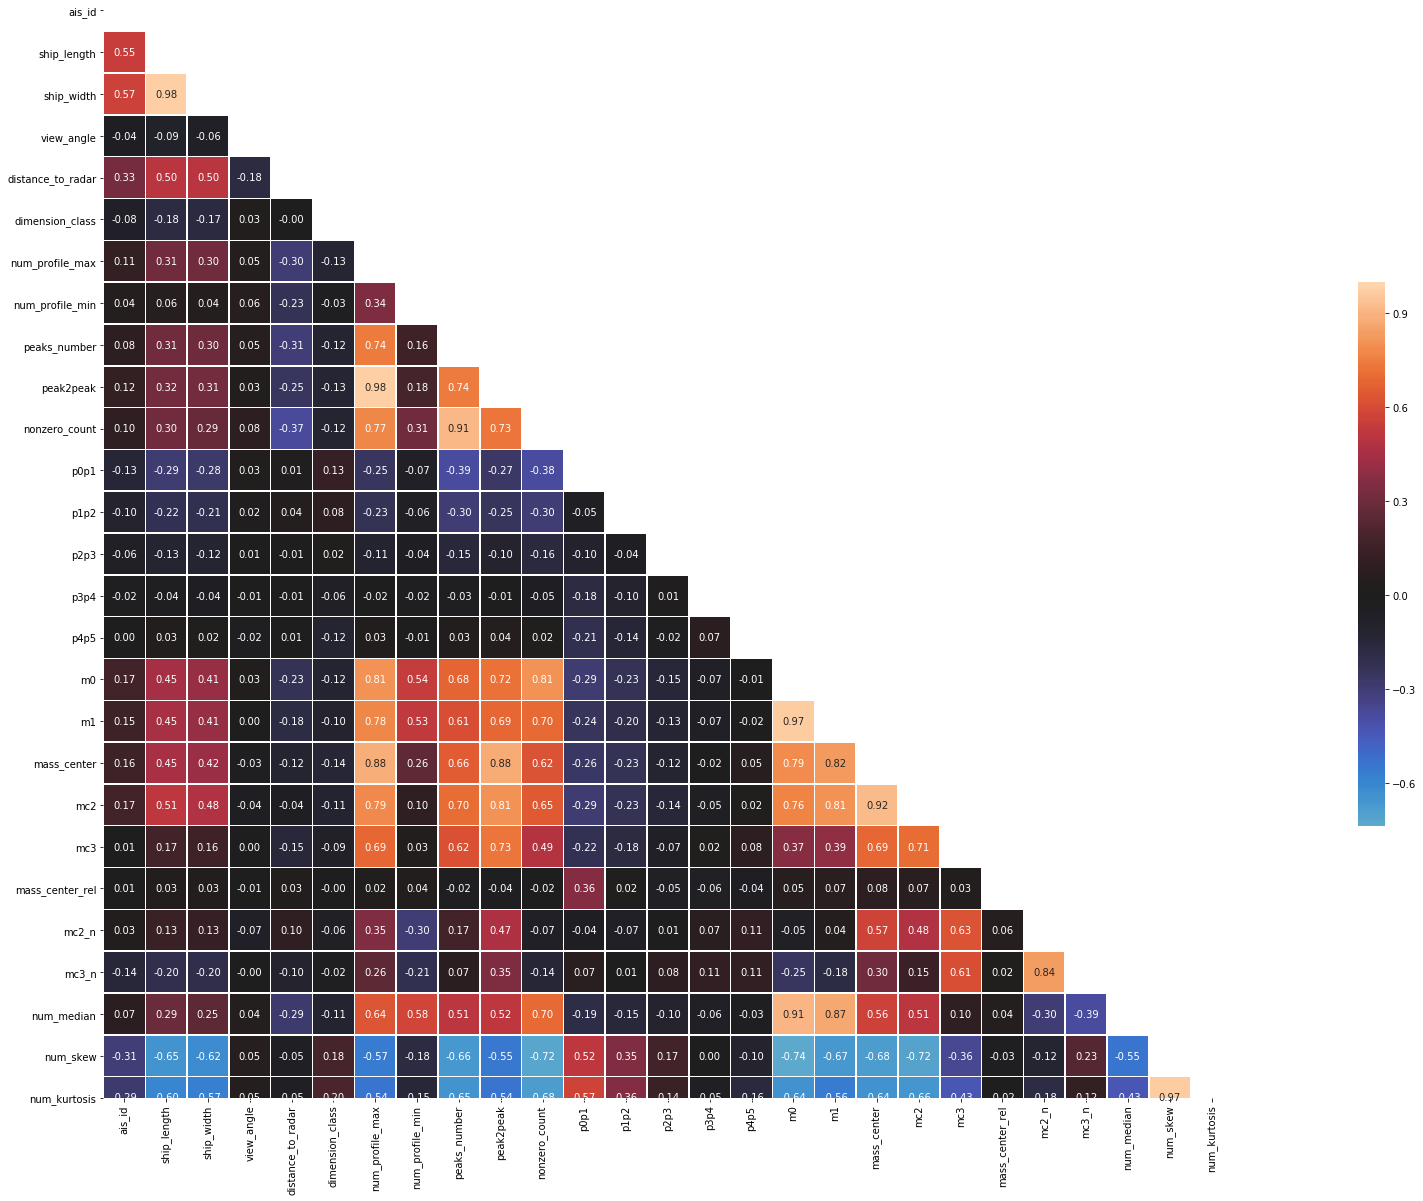

In [78]:
draw_heatmap(data)

In [3]:
data = load_from_pickle('dataset.pkl')
num_profile_scaled = load_from_pickle('num_profile_scaled.pkl')

In [4]:
# num_profile_scaled1 = list([v*10000 for v in num_profile_scaled])
# num_profile_scaled1 = np.array(num_profile_scaled1)
# type(num_profile_scaled1)

In [5]:
#del num_profile_scaled1

In [6]:
data['num_profile'] = num_profile_scaled

In [7]:
%%time
# Найдем пики радарного профиля и проранжируем их по убыванию. Таким образом сможем использовать ранги пиков вместо абсолютных значений
data['result'] = data['num_profile'].apply(lambda d: rank_peaks(d, height=0.005, notpeaks = 200))
data['ranked_values'] = data['result'].apply(lambda s: s['x'])
data['peaks_number'] = data['result'].apply(lambda s: s['peaks_number'])
data['peaks_vals'] = data['result'].apply(lambda s: s['peaks_vals']['peak_heights'])
# peak to peak
data['peak2peak'] = data['peaks_vals'].apply(lambda d: np.ptp(d))
data.drop('result', inplace=True, axis=1)
# Дополним массив пиков нулями до 200 элементов, чтобы можно было дальше работать с массивами одинаковой длины
data['peaks_vals'] = data['peaks_vals'].apply(lambda a: np.pad(a, mode='constant', pad_width=(0,200-len(a)), constant_values=0))
data['peaks_vals_sorted'] = data['peaks_vals'].apply(lambda d: np.flip(np.sort(d)))

data['nonzero_count'] = data['num_profile'].apply(lambda d: np.count_nonzero(d))
data['p0p1'] = data['peaks_vals_sorted'].apply(lambda d: d[0]/(d[1]+1))
data['p1p2'] = data['peaks_vals_sorted'].apply(lambda d: d[1]/(d[2]+1))
data['p2p3'] = data['peaks_vals_sorted'].apply(lambda d: d[2]/(d[3]+1))
data['p3p4'] = data['peaks_vals_sorted'].apply(lambda d: d[3]/(d[4]+1))
data['p4p5'] = data['peaks_vals_sorted'].apply(lambda d: d[4]/(d[5]+1))

data['m0'] = data['num_profile'].apply(lambda d: np.mean(d))
data['m1'] = data['num_profile'].apply(lambda d: np.mean(d**2))
data['mass_center'] = data['m1']/(data['m0']+1)
data['mc2'] = data['num_profile'].apply(lambda d: moment(d, moment=2))
data['mc3'] = data['num_profile'].apply(lambda d: moment(d, moment=3))
data['mass_center_rel'] = data['mass_center']/(data['peak2peak']+1)
data['mc2_n'] = data['mc2']/(data['m0']+1)
data['mc3_n'] = data['mc3']/(data['m0']+1)
data['num_median'] = data['num_profile'].apply(lambda d: np.median(d))
data['num_skew'] = data['num_profile'].apply(lambda d: skew(d))
data['num_kurtosis'] = data['num_profile'].apply(lambda d: kurtosis(d))

c:\users\jul\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys
c:\users\jul\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys


Wall time: 3min 43s


In [8]:
save_to_pickle(data, 'dataset_scaled.pkl')

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ais_id,403418.0,2.809985e+08,1.009711e+08,2.051530e+08,2.273152e+08,2.350593e+08,2.569020e+08,6.360928e+08
ship_length,403418.0,1.383209e+02,1.155209e+02,0.000000e+00,1.600000e+01,1.150000e+02,2.440000e+02,4.000000e+02
ship_width,403418.0,2.310961e+01,1.802200e+01,0.000000e+00,6.000000e+00,1.800000e+01,3.600000e+01,6.000000e+01
view_angle,403418.0,1.880346e+00,1.107486e+02,-1.799995e+02,-9.282073e+01,2.332702e+00,9.540777e+01,1.799988e+02
distance_to_radar,403418.0,2.186869e+04,1.562489e+04,7.444847e+02,8.559075e+03,1.836479e+04,2.897994e+04,9.232359e+04
dimension_class,403418.0,1.504653e+00,1.014313e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
num_profile_max,403418.0,9.103699e+01,3.177519e+01,1.200000e+01,6.700000e+01,9.300000e+01,1.170000e+02,2.550000e+02
num_profile_min,403418.0,8.925730e-01,3.448662e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e+01
peaks_number,403418.0,3.293613e+01,1.648648e+01,0.000000e+00,1.800000e+01,3.600000e+01,4.700000e+01,7.300000e+01
peak2peak,403418.0,9.653782e-01,5.735810e-02,0.000000e+00,9.649000e-01,9.833000e-01,9.889000e-01,9.945000e-01


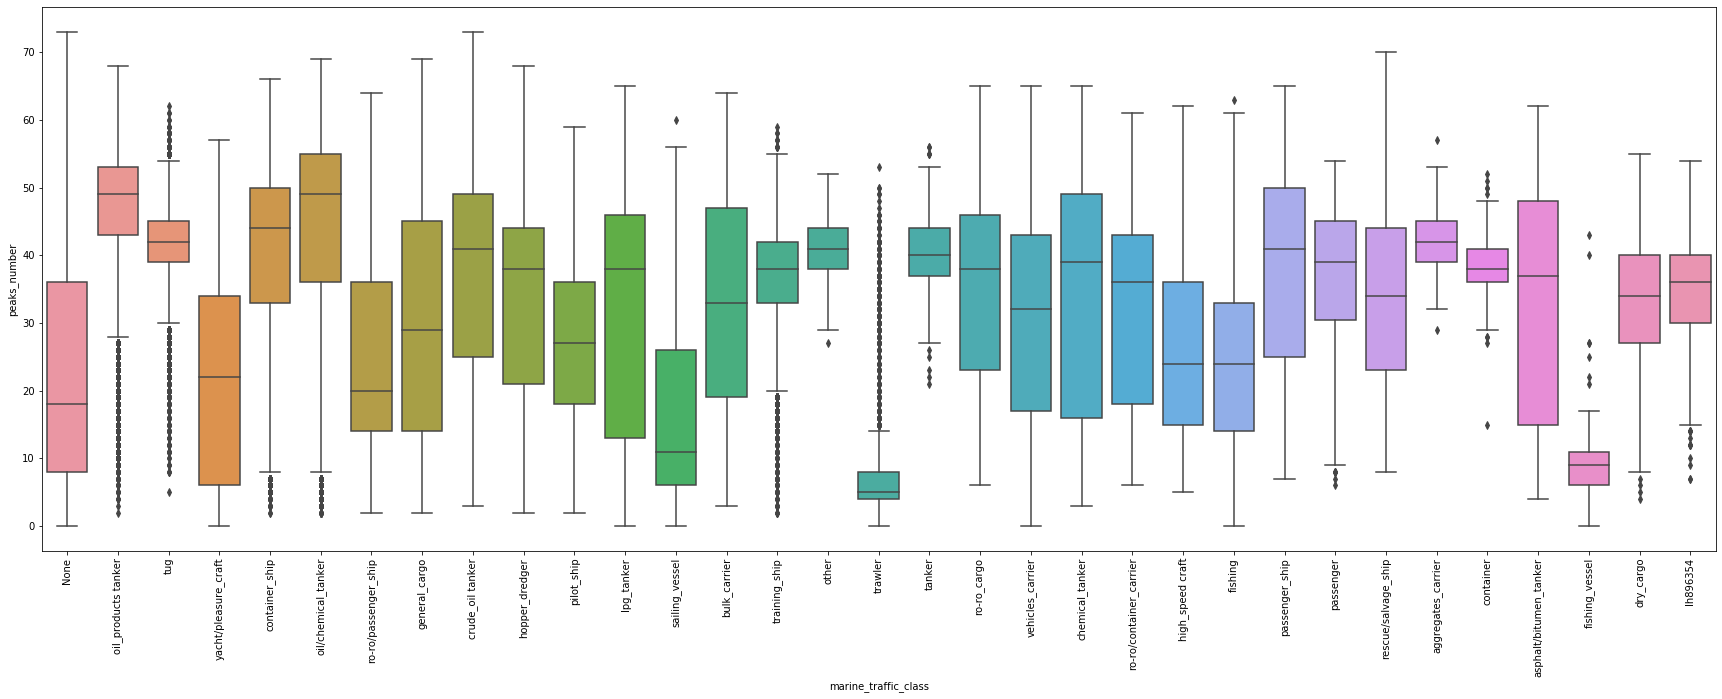

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10))
plt.xticks(rotation='vertical')
sns.boxplot(x="marine_traffic_class", y="peaks_number", data=data, ax=ax)

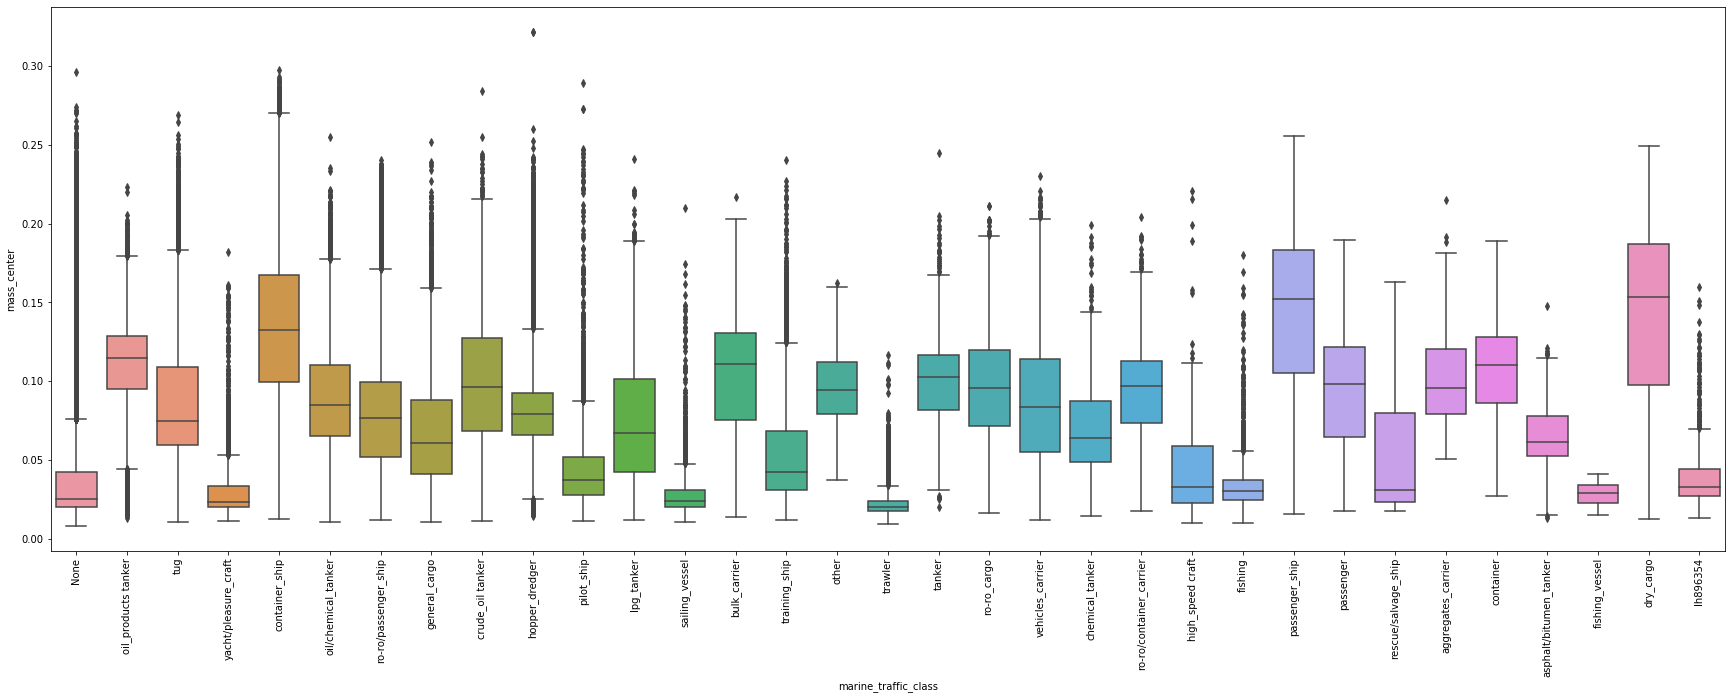

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10))
plt.xticks(rotation='vertical')
sns.boxplot(x="marine_traffic_class", y="mass_center", data=data, ax=ax)